In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input/favorita-grocery-sales-forecasting"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [3]:
# Reading the training and test set dataset of the store
#data =pd.read_csv("../input/train-sample1/train_sample_1.csv")
# Reading the training and test set dataset of the store
#data = pd.read_csv("../input/train-sample1/train_sample_1.csv")
#data = pd.read_csv("../input/train-10m-file1/train_sample_3.csv")
data = pd.read_csv("D:/data/favorita/train.csv")
holiday = pd.read_csv("D:/data/favorita/holidays_events.csv")
stores = pd.read_csv("D:/data/favorita/stores.csv")
oils = pd.read_csv("D:/data/favorita/oil.csv")
items = pd.read_csv("D:/data/favorita/items.csv")

trans= pd.read_csv("D:/data/favorita/transactions.csv")
test_data = pd.read_csv("D:/data/favorita/test.csv")
datesTbl=pd.DataFrame({'date': pd.date_range('2013-01-01','2017-08-31'), 'day':1,'month':5,'year':2018,'season':4})
datesTbl.head()


C:\Users\ragha\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date,day,month,season,year
0,2013-01-01,1,5,4,2018
1,2013-01-02,1,5,4,2018
2,2013-01-03,1,5,4,2018
3,2013-01-04,1,5,4,2018
4,2013-01-05,1,5,4,2018


In [4]:
# Fill NAs in oil with the average value for that month
oils.loc[:,'date'] = pd.to_datetime(oils.loc[:,'date'], errors='coerce')
oils = oils.assign(month=oils['date'].dt.strftime('%m'),year =  oils['date'].dt.strftime('%Y'))
oil_table = oils.pivot_table(values='dcoilwtico', index=['month','year'], aggfunc=np.mean)
def getAverageOilvalue(oil):
    return np.round(oil_table.loc[oil['month'],oil['year']]['dcoilwtico'],2)
oils['dcoilwtico'].fillna(oils[oils.iloc[:,1].isnull()].apply(getAverageOilvalue,axis = 1), inplace=True)
oils = oils.iloc[:,0:2]

In [5]:
#Change the date in the input and test to datetime and fill na 
data.loc[:,'date'] = pd.to_datetime(data.loc[:,'date'], errors='coerce')
data.loc[:,'onpromotion'] = data['onpromotion'].fillna(False)
test_data.loc[:,'date'] = pd.to_datetime(test_data.loc[:,'date'], errors='coerce')
# No NAS for on promotion in test data

In [ ]:
#test_data.apply(lambda x: sum(x.isnull()))
oil_table
datesTbl.groupby(['year'])['month'].max()


In [6]:
# Encode onpromotion  prior to join to save space
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()  
data['onpromotion'] = le.fit_transform(data['onpromotion'])
test_data['onpromotion'] = le.fit_transform(test_data['onpromotion'])

In [7]:
# Get all the date table entries
from datetime import date as dte
def getSeason(month):
    if month in ['01','02','03']:
        season = 1
    elif month in ['04','05','06']:
        season = 2
    elif month in ['07','08','09']:
        season = 3
    else:
        season = 4
    return season    

#data_new = data_new.assign(day=data_new['date'].dt.strftime('%d'),month=data_new['date'].dt.strftime('%m'),year =  data_new['date'].dt.strftime('%Y'))
#data_new['month'],data_new['year'] = data_new.date.apply(getMonthYear)
#data_new = data_new.assign(month=data_new.date.apply(lambda x: x.month),year =  data_new.date.apply(lambda x: x.year))
#data_new = data_new.assign(season=data_new.month.apply(getSeason))

datesTbl.loc[:,'day'] = datesTbl['date'].dt.strftime('%d')
datesTbl.loc[:,'month'] = datesTbl['date'].dt.strftime('%m')
datesTbl.loc[:,'year'] = datesTbl['date'].dt.strftime('%Y')
datesTbl.loc[:,'season'] = datesTbl.month.apply(getSeason)

In [8]:
trans.loc[:,'date'] = pd.to_datetime(trans.loc[:,'date'], errors='coerce')
#trans.apply(lambda x: sum(x.isnull()))
#trans.head()
trans = trans.assign(month=trans['date'].dt.strftime('%m'),year =  trans['date'].dt.strftime('%Y'))
trans_table = trans.pivot_table(values='transactions', index=['month','year','store_nbr'], aggfunc=np.mean)
def getAverageTransactions(trans):
    return np.round(trans_table.loc[trans['month'],trans['year'],trans['store_nbr']]['transactions'])

In [9]:
#Process item and store

def getFamily(family):
    if family in ['BREAD/BAKERY', 'DELI', 'POULTRY','EGGS', 'MEATS', 'SEAFOOD', 'PREPARED FOODS', 'PRODUCE', 'FROZEN FOODS', 'DAIRY','FOOD']:
        seg = 'FOOD'
    elif family in ['LIQUOR,WINE,BEER', 'BEVERAGES','DRINK']:
        seg = 'DRINK'
    elif family in ['PERSONAL CARE', 'LINGERIE','BEAUTY','BABY CARE','LADIESWEAR', 'CLOTHING and CARE']:
        seg = 'CLOTHING and CARE'
    elif family in ['MAGAZINES','SCHOOL AND OFFICE SUPPLIES','CELEBRATION','BOOKS','STATIONARY']:
        seg = 'STATIONARY'
    elif family in ['CLEANING','LAWN AND GARDEN','HOME CARE','HOME APPLIANCES', 'HOME AND KITCHEN II','HOME AND KITCHEN I','HOME ITEMS']:
        seg = 'HOME ITEMS'
    elif family in ['GROCERY I','GROCERY II','GROCERY']:
        seg = 'GROCERY'
    else:
        seg = 'MISC'
    return seg  

items.family = items.family.apply(getFamily)
#encode  family before join
items['family'] = le.fit_transform(items['family'])
stores['type'] = le.fit_transform(stores['type'])

In [10]:
#Process holidays
def getHoliday(holiday):
    if holiday in ['Holiday', 'Event']:
        seg = 'Holiday'
    elif holiday in ['Transfer', 'Bridge', 'Special']:
        seg = 'Special'
    elif holiday in ['Work Day']:
        seg = 'Work Day'
    else:
        seg = 'Additional'
    return seg  

#remove duplicate dates from this file
holi_nodup= holiday.drop_duplicates('date')
holi_nodup.loc[:,'date'] = pd.to_datetime(holi_nodup.loc[:,'date'], errors='coerce')
# Add weights to items file based on perishable
items = items.assign(wt=items.perishable.apply(lambda x: 1.5 if x == 1 else 1.0))
holi_nodup = holi_nodup.iloc[:,0:2]
holi_nodup.loc[:,'type'] =holi_nodup.type.apply(getHoliday)
holi_nodup.type.unique()


C:\Users\ragha\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


array(['Holiday', 'Special', 'Additional', 'Work Day'], dtype=object)

In [11]:
#Merge all small files with dates table
# Merging Oil and filling NA's
datesTbl_new= pd.merge(datesTbl,oils, on='date',how='left')
datesTbl_new['dcoilwtico'].fillna(datesTbl_new[datesTbl_new['dcoilwtico'].isnull()].apply(getAverageOilvalue,axis = 1), inplace=True)

#Merging holiday, filling NA's and encoding
datesTbl_new = pd.merge(datesTbl_new,holi_nodup, on='date',how='left')
datesTbl_new.type = datesTbl_new.type.fillna("Work Day")
datesTbl_new['type'] = le.fit_transform(datesTbl_new['type'])

#Merging transactions
#datesTbl_new = pd.merge(datesTbl_new,transactions, on=['date','store_nbr'],how='left')

#Get day of the week
datesTbl_new = datesTbl_new.assign(dow=datesTbl_new.date.apply(dte.weekday))


In [12]:
#Merge date tables and train and test data 
data_new = pd.merge(data,datesTbl_new, on='date',how='left')
test_new = pd.merge(test_data,datesTbl_new, on='date',how='left')
#Stores, transaction and item merging 
data_new = pd.merge(data_new,stores, on='store_nbr',how='left')
test_new = pd.merge(test_new,stores, on='store_nbr',how='left')
data_new = pd.merge(data_new,items, on='item_nbr',how='left')
test_new = pd.merge(test_new,items, on='item_nbr',how='left')
#data_new = pd.merge(data_new,transactions, on=['date','store_nbr'],how='left')
#test_new = pd.merge(test_new,transactions, on=['date','store_nbr'],how='left')
#data_new['type_y'] = le.fit_transform(data_new['type_y'])
#test_new['type_y'] = le.fit_transform(test_new['type_y'])
data_new.unit_sales = data_new.unit_sales.apply(lambda x: 0 if x < 0 else x)


MemoryError: 

In [ ]:
#data_new.item_nbr.nunique()
#cnt = data_new[['id','store_nbr']].groupby('store_nbr').agg(['count'])
#top_5_stores = cnt.sort_values([('id','count')],ascending=False).iloc[0:5]
#mask = data_new['store_nbr'].apply(lambda x: x in top_5_stores.index)
#sample = data_new[mask]
#sample.head()

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


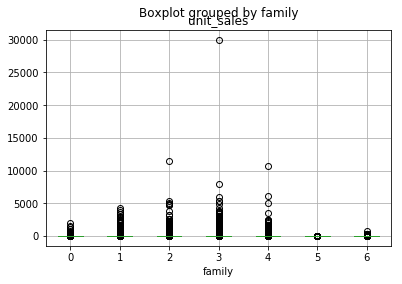

In [15]:
data_new.boxplot('unit_sales',by = 'family')

In [14]:
data_new.head()

,Unnamed: 0,id,date,store_nbr,item_nbr,unit_sales,onpromotion,day,month,season,...,type_x,dow,city,state,type_y,cluster,family,class,perishable,wt
0,33064456,33064456,2014-10-15,1,1463820,22.0,0,15,10,4,...,3,2,Quito,Pichincha,3,13,1,1148,0,1.0
1,84511441,84511441,2016-07-09,37,311954,1.0,0,09,07,3,...,3,5,Cuenca,Azuay,3,2,4,3006,0,1.0
2,59951838,59951838,2015-10-22,23,1148719,1.0,0,22,10,4,...,3,3,Ambato,Tungurahua,3,9,3,1032,0,1.0
3,82520568,82520568,2016-06-18,47,1584365,9.0,0,18,06,2,...,3,5,Quito,Pichincha,0,14,0,7780,0,1.0
4,61235692,61235692,2015-11-05,21,119193,4.0,0,05,11,4,...,3,3,Santo Domingo,Santo Domingo de los Tsachilas,1,6,4,3044,0,1.0


In [ ]:
test_new.head()

In [ ]:
data_new.iloc[:,[5,9,10,16,18]].pivot_table( index="family",columns=["type_y","season"],values="unit_sales",aggfunc=np.sum).transpose()


In [ ]:
print(data_new[data_new.unit_sales < 0])

In [ ]:
#Creating metrics
def nwrmsle(w,predict,y):
    # Compute the normalized weighted root mean square lograthamic error
    # Arg1 : array of Weights for each target value
    # Arg 2: array of predictions
    # Arg 3: array of true values
    sum_weights = np.sum(w)
    #print ("sum_weights:",sum_weights)
    numerator = np.sum(np.multiply(np.square(np.log(predict + 1) - np.log(y + 1)),w))
    if sum_weights == 0:
        print ("denominator 0")
        return 9999
    else:
        val = np.sqrt(numerator/sum_weights)
        return val

w = np.array([0, 0 , 0])
p = np.array([1, 545, 10])
y = np.array([5,545, 10])
print(nwrmsle(w,p,y))

In [ ]:
from sklearn.model_selection import train_test_split
X,y = data_new[data_new.columns.difference(['unit_sales'])], data_new.iloc[:,5]
X_train, X_test, y_train , y_test = train_test_split(X,y,test_size = 0.3, random_state =0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
print(y_train[y_train < 0])

In [ ]:
# Creating training pipeline
def train_predict(model,predictors,X_train,y_train,X_test,y_test):
    result = {}
    print('Starting..')
    start = time()
    model = model.fit(X_train[predictors],y_train)
    end = time()
    result['train_time'] = end - start
    print('Training ended. Starting prediction for train..')
    start = time()
    predict_train = model.predict(X_train[predictors][:10000])
    #print("Y value:",y_train[2065:2070])
    #print("P Value:",predict_train[2065:2070])
    end = time()
    result['train_pred_time'] = end - start
    print('Predicting training ended. Starting prediction for test..')
    start = time()
    predict_test = model.predict(X_test[predictors])
    #print(predict_test[:10])
    end = time()
    result['test_pred_time'] = end - start
    print('Getting scores..')
    result['train_score'] = nwrmsle(X_train['wt'][:10000],predict_train,y_train[:10000])
    result['test_score'] = nwrmsle(X_test['wt'],predict_test,y_test)
    result['model'] = model
    print ("{} trained with training time: {}".format(model.__class__.__name__,result['train_time']))
    print ("Prediction time for train data: {} and score = {}".format(result['train_pred_time'],result['train_score']))
    print ("Prediction time for test data: {} and score = {}".format(result['test_pred_time'],result['test_score']))
    return result


In [ ]:
from sklearn import metrics
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

#predictors =  ['store_nbr','item_nbr','day','month','season','dow','onpromotion']
#predictors =  ['store_nbr','onpromotion','type_x','type_y','family','item_nbr','day','month','season','dow','dcoilwtico']
predictors =  ['store_nbr','onpromotion','type_x','type_y','family','item_nbr','dow','perishable']
clf1 = linear_model.LinearRegression()
result1 = train_predict(clf1,predictors,X_train,y_train,X_test,y_test)

clf2 = DecisionTreeRegressor(max_depth=4,random_state = 0,min_samples_leaf  = 20)
result2 = train_predict(clf2,predictors,X_train,y_train,X_test,y_test)


#clf = clf.fit(X_train[predictors],y_train)
#t_predictions = clf.predict(X_train[predictors]) 
#t_mse = metrics.mean_squared_error(t_predictions,y_train)  
#print("train MSE :", t_mse)
#predictions = clf.predict(X_test[predictors])    
#mse = metrics.mean_squared_error(predictions,y_test)  
#print("test MSE :", mse)

In [ ]:
print(result2['model'].feature_importances_)

In [ ]:
model = result2['model']
test_new['unit_sales'] = model.predict(test_new[predictors])  
test_out=test_new[['id','unit_sales']]
test_out.to_csv('sales_submission.csv',header=True,index = False)